##### Copyright 2020 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Swap curve fitting in TensorFlow Quant Finance (TFF)

TensorFlow Finance has built-in library for unconstrained numerical optimization. This notebook shows how to use it.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google/tf-quant-finance/blob/master/tf_quant_finance/examples/jupyter_notebooks/Swap_Curve_Fitting.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/google/tf-quant-finance/blob/master/tf_quant_finance/examples/jupyter_notebooks/Swap_Curve_Fitting.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In [ ]:
#@title Install TF Quant Finance
!pip install 'tensorflow>=2.1.0'
!pip install tf-quant-finance

In [ ]:
#@title Imports
from datetime import datetime

import tensorflow as tf
import tensorflow_probability as tfp
import functools
import matplotlib.colors as colors

import tf_quant_finance as tff
import tf_quant_finance.datetime as dates

from matplotlib import pyplot as plt
from IPython.core.pylabtools import figsize

# Import seaborn if you want to have fancy visualization
# import seaborn as sns
# sns.set(style="darkgrid")

figsize(12, 8)

## Build instrument cashflows

The following functions are used to build the cashflows on the fixed and floating legs for curve fitting.

### 1. Cash instruments

Cash instruments generate the cashflow by simple spot rate, i.e.

$$[1 + R \cdot \tau] \cdot DF(\tau) = 1$$

where $\tau$ is the tenor of the instrument, $R$ is the market rate and $DF(\tau)$ is the discount factor at time $\tau$.

In [ ]:
#@title 1. Cash instruments
def build_spot_cash_instrument(tenor, close, dtype, **kwargs):
    """Build spot cash instrument.
    
    Args:
      tenor: `dates.PeriodTensor`. Defined the tenor of the floating rate.     
      close: `float64`. Defined the close rate of the instrument.
        
    Returns:
      A `dict` containing the inputs for swap_curve_fit, e.g. 
      `float_leg_start_time`.
    """
    assert tenor.period_type() == dates.PeriodType.MONTH
    tenor = tenor.quantity().numpy() / 12.0
    return {
        'float_leg_start_time': tf.constant([0.0], dtype=dtype),
        'float_leg_end_time': tf.constant([tenor], dtype=dtype),
        'float_leg_daycount': tf.constant([tenor], dtype=dtype),
        'fixed_leg_start_time': tf.constant([0.0], dtype=dtype),
        'fixed_leg_end_time': tf.constant([tenor], dtype=dtype),
        'fixed_leg_daycount': tf.constant([tenor], dtype=dtype),
        'fixed_leg_cashflow': tf.constant([-close], dtype=dtype),
        'pv': 0.0,
        'initial_curve_rate': 1e-6,
    }

### 2. Forward and Future instruments

Forward instruments, similar to cash instruments, generate the cashflow by simple spot rate on a specified forward date, i.e.

$$[1 + R \cdot \tau(t_1, t_2)] \cdot DF(t_2) - DF(t_1) = 0$$

where $t_1$ is the forward start time, $t_2$ is the maturity time, $\tau(t_1, t_2)$ is the tenor of the instrument, and R is the market rate.

The difference between the forward and future rates is the convexity adjustment. Since the difference is minimal for instrument less then 2Y maturity, it is assumed to be the same for simplicity here.

In [ ]:
#@title 2. Forward and Future instruments
def build_futures_instrument(        
        settle_date, maturity_date, close, tenor, dtype, **kwargs):
    """Build futures instrument.
    
    Args:
      settle_date: `datetime.datetime`. Defines the date when the instrument
        is settled.
      maturity_date: `datetime.datetime`. Defines the maturity date of the 
        instrument.
      close: `float64`. Defined the close rate of the instrument.
      tenor: `dates.PeriodTensor`. Defined the tenor of the floating rate.       
        
    Returns:
      A `dict` containing the inputs for swap_curve_fit, e.g. 
      `float_leg_start_time`.
    """
    assert tenor.period_type() == dates.PeriodType.MONTH
    tenor = tenor.quantity().numpy() / 12.0
    
    start = daycount(
        start_date=dates.dates_from_datetimes([settle_date]),
        end_date=dates.dates_from_datetimes([maturity_date]),
        dtype=dtype
    )
    
    return {
        'float_leg_start_time': start,
        'float_leg_end_time': start + tenor,
        'float_leg_daycount': tf.constant([tenor], dtype=dtype),
        'fixed_leg_start_time': start,
        'fixed_leg_end_time': start + tenor,
        'fixed_leg_daycount': tf.constant([tenor], dtype=dtype),
        'fixed_leg_cashflow': tf.constant([-close], dtype=dtype),
        'pv': 0.0,
        'initial_curve_rate': 1e-6,
    }    

### 3. Swap instruments

Given a pre-defined notional principal $K$, the present value of the fixed leg can be expressed as

$$ PV(fixed) = \sum_{i=1}^{N_{fixed}} [K \cdot R \cdot \tau(i) \cdot DF(t_i)] + K \cdot DF(t_{N_{fixed}}) $$

where $R$ is the market rate, $N_{fixed}$ is the total number of fixed leg payments, $\tau(i)$ is the day count fraction that determines the $i^{th}$ payment amount, $DF(t_1)$ is the discount factor at $i^{th}$ payment time t. 

Same for the present value of the floating leg

$$ PV(floating) = \sum_{i=1}^{N_{floating}} [K \cdot R(i) \cdot \tau(i) \cdot DF(t_i)] + K \cdot DF(t_{N_{floating}}) $$

where $R(i)$ is an effective rate to cover $i^{th}$ payment on the floating leg.

Under the no-arbitrage rule, the present value of the fixed and floating leg must be equal, i.e.

$$ PV(fixed) = PV(floating) $$

In [ ]:
#@title 3. Swap instruments
def build_swap_instrument(
        settle_date, maturity_date, close, fixed_tenor, float_tenor, daycount,
        roll_convention, dtype, **kwargs):
    """Build futures instrument.
    
    Args:
      settle_date: `datetime.datetime`. Defines the date when the instrument
        is settled.
      maturity_date: `datetime.datetime`. Defines the maturity date of the 
        instrument.
      close: `float64`. Defined the close rate of the instrument.
      fixed_tenor: `float64`. Defined the tenor of the fixed rate.
      float_tenor: `float64`. Defined the tenor of the floating rate.
      daycount: `callable`. Defines the daycount convention function imported
          from `dates.daycounts`.
      roll_convention: `dates.BusinessDayConvention`. Defines the roll
          convention.
      dtype: `tf.Dtype`. If supplied the dtype for the (elements of)
        `float_leg_start_times`, and `fixed_leg_start_times`.
        Default value: None which maps to the default dtype inferred by
        TensorFlow.   
          
    Returns:
      A `dict` containing the inputs for swap_curve_fit, e.g. 
      `float_leg_start_time`.
    """    
    settle_date = dates.dates_from_datetimes([settle_date])
    maturity_date = dates.dates_from_datetimes([maturity_date])
    float_leg_dates = dates.PeriodicSchedule(
        start_date=settle_date,
        end_date=maturity_date,
        tenor=float_tenor,
        roll_convention=roll_convention,
        backward=False).dates()[0]  
    fixed_leg_dates = dates.PeriodicSchedule(
        start_date=settle_date,
        end_date=maturity_date,
        tenor=fixed_tenor,
        roll_convention=roll_convention,
        backward=False).dates()[0]          
        
    return {
        'float_leg_start_time': daycount(
            start_date=settle_date, 
            end_date=float_leg_dates[:-1],
            dtype=dtype),
        'float_leg_end_time': daycount(
            start_date=settle_date, 
            end_date=float_leg_dates[1:],
            dtype=dtype),
        'float_leg_daycount': daycount(
            start_date=float_leg_dates[:-1],
            end_date=float_leg_dates[1:],
            dtype=dtype),
        'fixed_leg_start_time': daycount(
            start_date=settle_date, 
            end_date=fixed_leg_dates[:-1],
            dtype=dtype),
        'fixed_leg_end_time': daycount(
            start_date=settle_date, 
            end_date=fixed_leg_dates[1:],
            dtype=dtype),
        'fixed_leg_daycount': daycount(
            start_date=fixed_leg_dates[:-1],
            end_date=fixed_leg_dates[1:],
            dtype=dtype),
        'fixed_leg_cashflow': tf.repeat(
            tf.constant(-close, dtype=dtype), 
            repeats=fixed_leg_dates.shape[0] - 1, 
        ),
        'pv': 0.0,
        'initial_curve_rate': 1e-6,
    }

## Fit the interest rate curve

The data is retrieved from Bloomberg on 2020-02-14 to fit the USD LIBOR 3M curve. 

The following market instruments are used

- LIBOR Fixed 3 Month: Spot LIBOR 3M rate

- ED Futures: Eurodollar Futures with expiry up to 2Y

- Interest Rate Swap: Liquid interest rate swap instruments with tenors from 2 years to 50 years

In [ ]:
float_leg_start_times = []
float_leg_end_times = []
float_leg_daycounts = []
fixed_leg_start_times = []
fixed_leg_end_times = []
fixed_leg_daycounts = []
fixed_leg_cashflows = []
pvs = []
initial_curve_rates = []

# Global dtype
dtype = tf.float64

# Global daycount - Fit on USD curve
daycount = dates.daycount_actual_360

# Global roll convention - Backward
roll_convention = dates.BusinessDayConvention.PRECEDING

# The fixed leg payment frequency is 6M
fixed_tenor = dates.periods.months(6)

# The floating rate is always USD LIBOR 3M
float_tenor = dates.periods.months(3)

instruments = [
    {'settle_date': '2020-02-19', 'maturity_date': '2020-05-21', 
     'close': 0.01696000000, 'name': 'USD3MD'},
    {'settle_date': '2020-02-19', 'maturity_date': '2020-06-17', 
     'close': 0.01669900000, 'name': 'EDH0'},
    {'settle_date': '2020-02-19', 'maturity_date': '2020-09-16', 
     'close': 0.01544400000, 'name': 'EDM0'},
    {'settle_date': '2020-02-19', 'maturity_date': '2020-12-16', 
     'close': 0.01468600000, 'name': 'EDU0'},
    {'settle_date': '2020-02-19', 'maturity_date': '2021-03-17', 
     'close': 0.01427500000, 'name': 'EDZ0'},
    {'settle_date': '2020-02-19', 'maturity_date': '2021-06-16', 
     'close': 0.01326200000, 'name': 'EDH1'},
    {'settle_date': '2020-02-19', 'maturity_date': '2021-09-15', 
     'close': 0.01299700000, 'name': 'EDM1'},
    {'settle_date': '2020-02-19', 'maturity_date': '2021-12-15', 
     'close': 0.01277900000, 'name': 'EDU1'},
    {'settle_date': '2020-02-19', 'maturity_date': '2022-03-16', 
     'close': 0.01295900000, 'name': 'EDZ1'},
    {'settle_date': '2020-02-19', 'maturity_date': '2022-06-15', 
     'close': 0.01288600000, 'name': 'EDH2'},
    {'settle_date': '2020-02-19', 'maturity_date': '2022-09-21', 
     'close': 0.01295900000, 'name': 'EDM2'},
    {'settle_date': '2020-02-19', 'maturity_date': '2022-12-21', 
     'close': 0.01308200000, 'name': 'EDU2'},
    {'settle_date': '2020-02-19', 'maturity_date': '2023-03-15', 
     'close': 0.01335500000, 'name': 'EDZ2'},
    {'settle_date': '2020-02-19', 'maturity_date': '2024-02-21', 
     'close': 0.01378410000, 'name': 'USDAM3L4Y'},
    {'settle_date': '2020-02-19', 'maturity_date': '2025-02-21', 
     'close': 0.01384037500
     , 'name': 'USDAM3L6Y'},
    {'settle_date': '2020-02-19', 'maturity_date': '2027-02-22', 
     'close': 0.01419340000, 'name': 'USDAM3L7Y'},
    {'settle_date': '2020-02-19', 'maturity_date': '2028-02-22', 
     'close': 0.01443062500, 'name': 'USDAM3L8Y'},
    {'settle_date': '2020-02-19', 'maturity_date': '2029-02-21', 
     'close': 0.01468025000, 'name': 'USDAM3L9Y'},
    {'settle_date': '2020-02-19', 'maturity_date': '2030-02-21', 
     'close': 0.01494412500, 'name': 'USDAM3L10Y'},
    {'settle_date': '2020-02-19', 'maturity_date': '2032-02-23', 
     'close': 0.01542162500, 'name': 'USDAM3L12Y'},
    {'settle_date': '2020-02-19', 'maturity_date': '2035-02-21', 
     'close': 0.01592825000, 'name': 'USDAM3L15Y'},
    {'settle_date': '2020-02-19', 'maturity_date': '2040-02-21', 
     'close': 0.01644683333, 'name': 'USDAM3L20Y'},
    {'settle_date': '2020-02-19', 'maturity_date': '2045-02-21', 
     'close': 0.01666350000, 'name': 'USDAM3L25Y'},
    {'settle_date': '2020-02-19', 'maturity_date': '2050-02-22', 
     'close': 0.01662650000, 'name': 'USDAM3L30Y'},
    {'settle_date': '2020-02-19', 'maturity_date': '2060-02-23', 
     'close': 0.01613000000, 'name': 'USDAM3L40Y'},
    {'settle_date': '2020-02-19', 'maturity_date': '2070-02-21', 
     'close': 0.01534000000, 'name': 'USDAM3L50Y'},
]

for instrument in instruments:
    instrument['settle_date'] = (
        datetime.strptime(instrument['settle_date'], '%Y-%m-%d')
    )
    instrument['maturity_date'] = (
        datetime.strptime(instrument['maturity_date'], '%Y-%m-%d')
    )    
    if instrument['name'] == 'USD3MD':
        # Spot instrument
        instrument = build_spot_cash_instrument(
            tenor=float_tenor, 
            dtype=dtype,
            **instrument
        )
    elif instrument['name'][:2] == 'ED':
        # Futures instrument
        instrument = build_futures_instrument(
            dtype=dtype,
            tenor=float_tenor, 
            **instrument
        )
    elif instrument['name'].startswith('USDAM3L'):
        # Swap instrument
        instrument = build_swap_instrument(
            fixed_tenor=fixed_tenor,
            float_tenor=float_tenor,
            roll_convention=roll_convention,
            daycount=daycount,
            dtype=dtype,
            **instrument
        )
    else:
        raise NotImplementedError(
            'Cannot recognize the type of instrument %s'
            % instrument['name']
        )
    
    float_leg_start_times.append(instrument['float_leg_start_time'])
    float_leg_end_times.append(instrument['float_leg_end_time'])
    float_leg_daycounts.append(instrument['float_leg_daycount'])
    fixed_leg_start_times.append(instrument['fixed_leg_start_time'])
    fixed_leg_end_times.append(instrument['fixed_leg_end_time'])
    fixed_leg_daycounts.append(instrument['fixed_leg_daycount'])
    fixed_leg_cashflows.append(instrument['fixed_leg_cashflow'])
    pvs.append(instrument['pv'])
    initial_curve_rates.append(instrument['initial_curve_rate'])
    
curve = tff.rates.swap_curve_fit(
    float_leg_start_times=float_leg_start_times,
    float_leg_end_times=float_leg_end_times,
    float_leg_daycount_fractions=float_leg_daycounts,
    fixed_leg_start_times=fixed_leg_start_times,
    fixed_leg_end_times=fixed_leg_end_times,
    fixed_leg_cashflows=fixed_leg_cashflows,
    fixed_leg_daycount_fractions=fixed_leg_daycounts,
    present_values=tf.constant(pvs, dtype=dtype),
    initial_curve_rates=tf.constant(initial_curve_rates, dtype))    

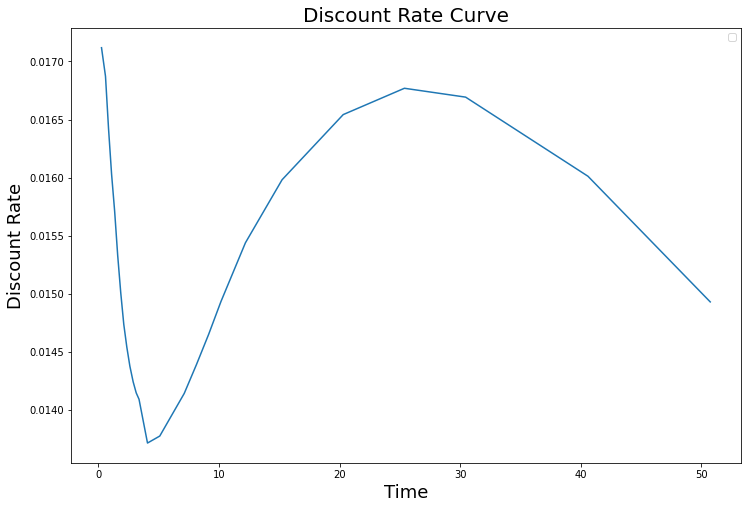

In [25]:
plt.plot(curve.times, curve.rates)
plt.title('Discount Rate Curve', fontsize=20)
plt.xlabel('Time', fontsize=18)
plt.ylabel('Discount Rate', fontsize=18)
plt.legend()
plt.show()

## Reference

[1] Bloomberg, Building the Bloomberg Interest Rate Curve – Definitions and Methodology, Mar 2016